Source: https://gist.github.com/VikingPenguinYT/665769ba03115b1a0888893eaf1d4f13

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli

In [2]:
class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
#         self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
#         self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_M = tf.Variable(tf.random_normal([n_in, n_out], stddev = 0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        # Eqn. (4)
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

Sample data

In [3]:
n_samples = 50
# X = np.random.normal(size=(n_samples, 1))
# y = np.random.normal(np.cos(5.*X) / (np.abs(X) + 1.), 0.1).ravel()
# X_pred = np.atleast_2d(np.linspace(-5., 5., num=500)).T
# X = np.hstack((X, X**2, X**3))
# X_pred = np.hstack((X_pred, X_pred**2, X_pred**3))

def dataset2(x):
    y = np.cos(np.pi*x) / (1.0 + np.abs(x))
    return y

num_samples = n_samples
sigma2 = 0.01
X = np.atleast_2d(np.random.standard_normal(size=(num_samples,1)))
y = dataset2(X) + np.sqrt(sigma2) * np.random.standard_normal((num_samples,1))
y = y.flatten()
X_pred = np.linspace(-10.0, +10.0, num = 500).reshape(500,1)

Create model

In [4]:
tf.reset_default_graph()

n_feats = X.shape[1]
n_hidden = 100
model_prob = 0.9
model_lam = 1e-2
model_X = tf.placeholder(tf.float32, [None, n_feats])
model_y = tf.placeholder(tf.float32, [None])
model_L_1 = VariationalDense(n_feats, n_hidden, model_prob, model_lam)
model_L_2 = VariationalDense(n_hidden, n_hidden, model_prob, model_lam)
model_L_3 = VariationalDense(n_hidden, 1, model_prob, model_lam)
model_out_1 = model_L_1(model_X, tf.nn.relu)
model_out_2 = model_L_2(model_out_1, tf.nn.relu)
model_pred = model_L_3(model_out_2)
model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
model_mse = model_sse / n_samples
model_loss = (
    # Negative log-likelihood.
    model_sse +
    # Regularization.
    model_L_1.regularization +
    model_L_2.regularization +
    model_L_3.regularization
) / n_samples
train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)

W0815 18:10:42.260314 140008807479040 deprecation.py:323] From <ipython-input-2-31756e240775>:6: Bernoulli.__init__ (from tensorflow.python.ops.distributions.bernoulli) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0815 18:10:42.267385 140008807479040 deprecation.py:323] From /opt/Miniconda2/envs/tf-1.14-generic/lib/python3.7/site-packages/tensorflow/python/ops/distributions/bernoulli.py:97: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distribution

Train model

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [6]:
for i in range(10000):
    sess.run(train_step, {model_X: X, model_y: y})
    if i % 100 == 0:
        mse = sess.run(model_mse, {model_X: X, model_y: y})
        print("Iteration {}. Mean squared error: {:.4f}.".format(i, mse))

# Sample from the posterior.
n_post = 1000
Y_post = np.zeros((n_post, X_pred.shape[0]))
for i in range(n_post):
    Y_post[i] = sess.run(model_pred, {model_X: X_pred})

Iteration 0. Mean squared error: 0.2218.
Iteration 100. Mean squared error: 0.1181.
Iteration 200. Mean squared error: 0.0514.
Iteration 300. Mean squared error: 0.3426.
Iteration 400. Mean squared error: 0.4635.
Iteration 500. Mean squared error: 0.0248.
Iteration 600. Mean squared error: 0.0279.
Iteration 700. Mean squared error: 0.0381.
Iteration 800. Mean squared error: 0.0648.
Iteration 900. Mean squared error: 0.0309.
Iteration 1000. Mean squared error: 0.0304.
Iteration 1100. Mean squared error: 0.0612.
Iteration 1200. Mean squared error: 0.0182.
Iteration 1300. Mean squared error: 0.0407.
Iteration 1400. Mean squared error: 0.3537.
Iteration 1500. Mean squared error: 0.0197.
Iteration 1600. Mean squared error: 0.0808.
Iteration 1700. Mean squared error: 0.0344.
Iteration 1800. Mean squared error: 0.0356.
Iteration 1900. Mean squared error: 0.0335.
Iteration 2000. Mean squared error: 0.0646.
Iteration 2100. Mean squared error: 0.0437.
Iteration 2200. Mean squared error: 0.0559.


In [7]:
# Sample from the posterior.
n_post = 1000
Y_post = np.zeros((n_post, X_pred.shape[0]))
for i in range(n_post):
    Y_post[i] = sess.run(model_pred, {model_X: X_pred})

Plot

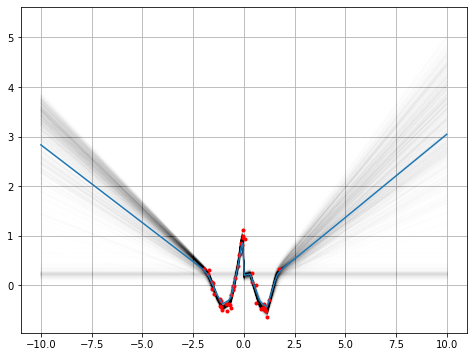

In [8]:
plt.figure(figsize=(8, 6))
for i in range(n_post):
    plt.plot(X_pred[:, 0], Y_post[i], "k-", alpha=1. / 200)
plt.plot(X[:, 0], y, "r.")
plt.plot(X_pred[:, 0], np.mean(Y_post.T, axis=1))
plt.grid()
plt.show()

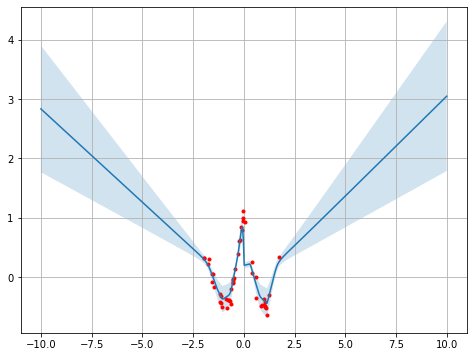

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0], y, "r.")
pred_mean = np.mean(Y_post.T, axis=1)
pred_std  = np.std(Y_post.T, axis=1)
plt.plot(X_pred[:,0], np.mean(Y_post.T, axis=1))
plt.fill_between(X_pred[:,0], pred_mean+pred_std, pred_mean-pred_std, alpha = 0.2)
plt.grid()
plt.show()

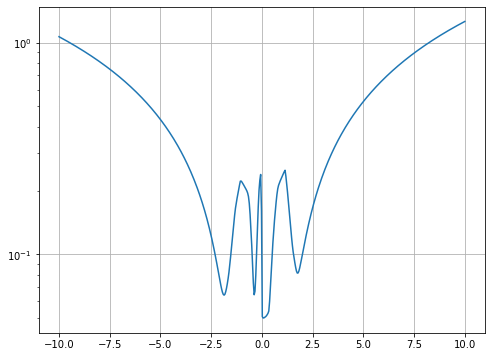

In [10]:
plt.figure(figsize=(8, 6))
plt.semilogy(X_pred[:,0], pred_std)
plt.grid(True)